# Análise de Mensagens do Telegram usando um Data Lake na AWS

Este notebook apresenta um pipeline completo de ingestão, processamento e análise de mensagens do Telegram utilizando serviços da AWS:

- **S3 (RAW e ENRICHED layers)**
- **AWS Lambda**
- **EventBridge**
- **Glue Crawler**
- **Athena (consultas SQL)**
- **Parquet particionado**

Mensagens foram enviadas ao data lake por meio de um gerador sintético de 10.000 registros, permitindo demonstrar um fluxo real de engenharia de dados sem expor informações sensíveis.

Este notebook apresenta:

1. Arquitetura do Data Lake  
2. Descrição das camadas RAW e ENRICHED  
3. Explicação das Lambdas e automações  
4. Importação dos dados processados (ENRICHED)  
5. Análise exploratória (EDA)  
6. Visualizações variadas  


## Arquitetura Geral do Pipeline

A figura abaixo ilustra toda a arquitetura implementada para ingestão, processamento,
armazenamento e consulta dos dados de mensagens do Telegram utilizando serviços da AWS.


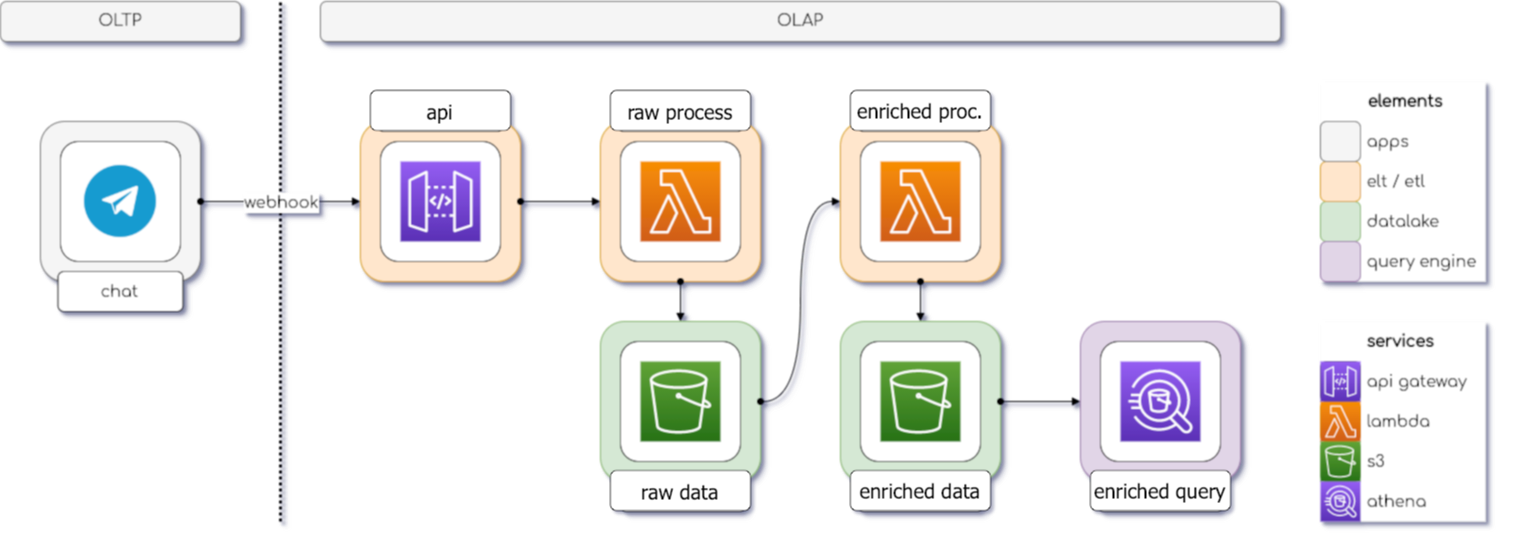

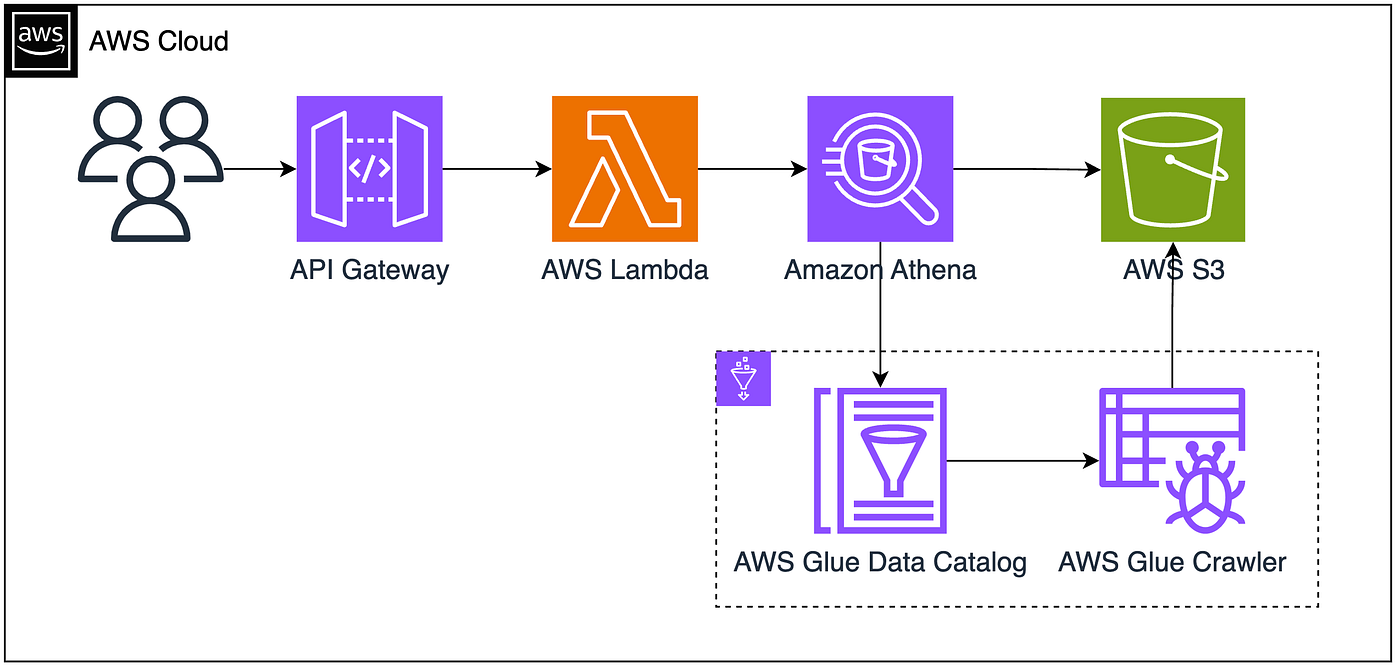

A solução segue um padrão moderno de Data Lake, dividido entre camadas OLTP e OLAP:

### 🔹 OLTP (Origem dos Dados)
- **Telegram Chat**: fonte das mensagens.
- **Webhook via API Gateway**: recebe eventos do Telegram e envia para a Lambda de ingestão.

### 🔹 OLAP – ETL/ELT
- **Lambda RAW Process**: salva o JSON original no S3, particionado por `context_date`.
- **EventBridge**: agenda a execução da Lambda de enriquecimento.
- **Lambda ENRICHED Process**: lê JSONs do RAW, normaliza os campos e escreve Parquet.

### 🔹 Data Lake
- **RAW Layer**: armazenamento dos arquivos JSON originais.
- **ENRICHED Layer**: armazenamento dos Parquets normalizados, prontos para consulta.

### 🔹 Query Engine
- **Glue Crawler**: identifica partições e atualiza o catálogo de dados.
- **Athena**: executa queries SQL sobre o ENRICHED, permitindo análises rápidas.

Essa pipeline garante:
- Escalabilidade  
- Baixo custo  
- Organização por camadas  
- Facilidade de análise posterior (Athena / Pandas)  


## Arquitetura do pipeline

O pipeline segue o padrão moderno de Data Lake:

**Telegram → API Gateway → Lambda RAW → S3 (RAW) → EventBridge → Lambda ENRICHED → S3 (ENRICHED, Parquet) → Glue Crawler → Athena**

### RAW Layer
- Armazena os JSON originais enviados pelo Telegram.
- Particionado por `context_date=YYYY-MM-DD`.

### ENRICHED Layer
- Contém arquivos Parquet com schema tabular.
- Dados normalizados e prontos para consulta.
- Cada dia gera um arquivo Parquet.

### Consultas
O Athena permite consultar o dataset transformado sem necessidade de servidores.


## 🧩 Componentes do Pipeline
Nesta seção descrevo rapidamente cada componente da arquitetura, na ordem em que os dados fluem pelo sistema.

## 1. Telegram (fonte OLTP)

O **Telegram** é a origem das mensagens. Em um cenário real, o bot recebe mensagens de usuários em um chat ou grupo específico.  
Neste projeto, gerei mensagens sintéticas simulando a atividade desse chat.


## 2. API Gateway (Webhook)

O **API Gateway** expõe um endpoint HTTP (webhook) que recebe os eventos enviados pelo Telegram.  
Ele funciona como a “porta de entrada” da AWS: tudo o que chega pelo webhook é repassado para a primeira função Lambda.
O endpoint foi configurado no modo Lambda proxy integration, permitindo que toda requisição seja repassada ao handler exatamente como recebida.

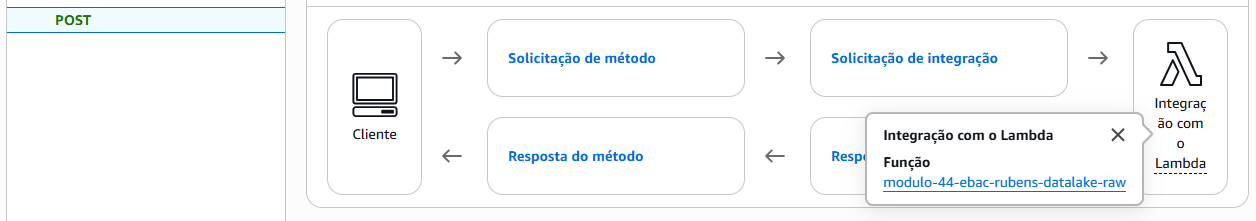

## 3. Lambda RAW (Ingestão)

A função **Lambda RAW** recebe o payload do API Gateway, faz a normalização básica do JSON e valida o `chat_id`.  
Quando a mensagem pertence ao chat configurado, a Lambda grava o evento bruto em um bucket S3, sem perder nenhum campo original.

O código do script pode ser conferido aqui [link](https://github.com/rubensgtavares/pipeline-demo-telegram/blob/main/raw.py)

## 4. S3 – RAW Layer (JSON)

A camada **RAW** é um bucket S3 particionado por data:  
`telegram/context_date=YYYY-MM-DD/arquivo.json`

Aqui ficam os arquivos **JSON brutos**, exatamente como chegaram do Telegram.  
Essa camada é imutável e serve como “fonte da verdade” histórica.


s3://modulo-44-ebac-rubens-datalake-raw/
    └── telegram/
        └── context_date=2025-11-04/
            ├── 20251104084321000000.json
            ├── 20251104084322000000.json
            └── ...


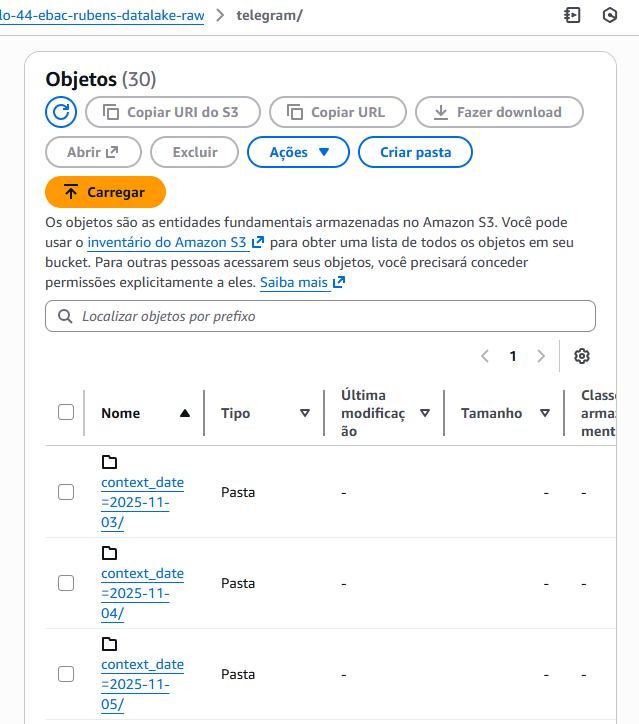

## 5. EventBridge (Orquestração)

O **EventBridge** agenda a execução da Lambda ENRICHED.  
Em vez de processar as mensagens uma a uma, ele dispara a transformação em lote (por exemplo, a cada X minutos ou 1 vez ao dia), lendo todos os arquivos RAW disponíveis.
A escolha por EventBridge garante desacoplamento e permite transformar os dados em lote, reduzindo custo por invocação.

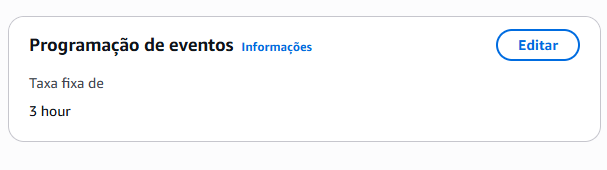

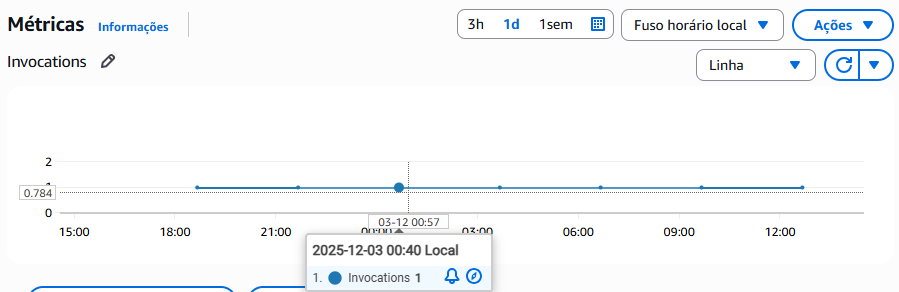

## 6. Lambda ENRICHED (Transformação)

A função **Lambda ENRICHED** lê os arquivos JSON da camada RAW, extrai os campos relevantes (ex.: `user_id`, `chat_id`, `text`, `date`, `context_date`), converte tipos e padroniza o schema.  
O resultado é escrito em formato **Parquet** em outro bucket S3, também particionado por data.

O script completo pode ser conferido aqui [link](https://github.com/rubensgtavares/pipeline-demo-telegram/blob/main/enriched.py)

schema final:

*  message_id: bigint
*  user_id: bigint
*  user_is_bot: boolean
*  user_first_name: string
*  chat_id: bigint
*  chat_type: string
*  text: string
*  date: bigint
*  context_date: string (partition)


## 7. S3 – ENRICHED Layer (Parquet)

A camada **ENRICHED** guarda os dados já tratados, em formato **Parquet**, que é mais eficiente para leitura analítica.  
O particionamento por `context_date` permite que consultas filtrem por dia, reduzindo custo e tempo de processamento.


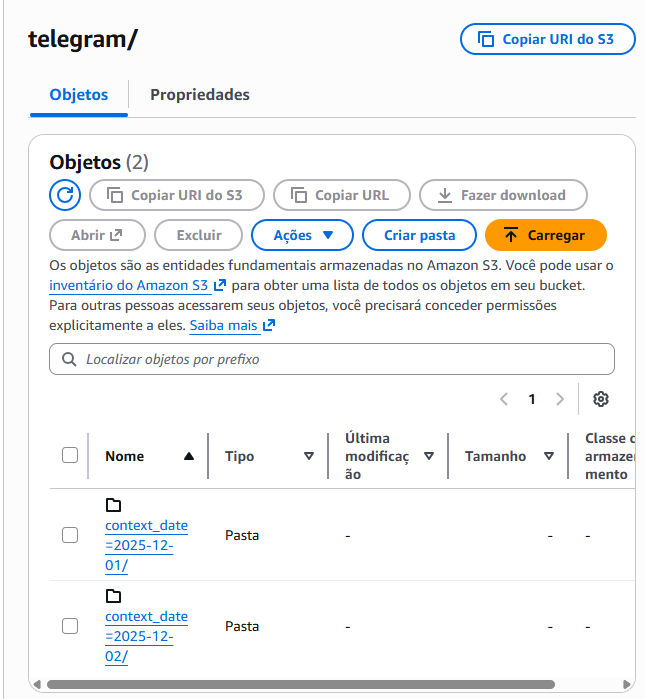

## 8. Glue Crawler (Catálogo)

O **Glue Crawler** varre a pasta do ENRICHED no S3, descobre automaticamente o schema (colunas, tipos) e as partições disponíveis.  
Com isso, ele atualiza o **Glue Data Catalog**, criando/atualizando a tabela `telegram` que será consultada pelo Athena.


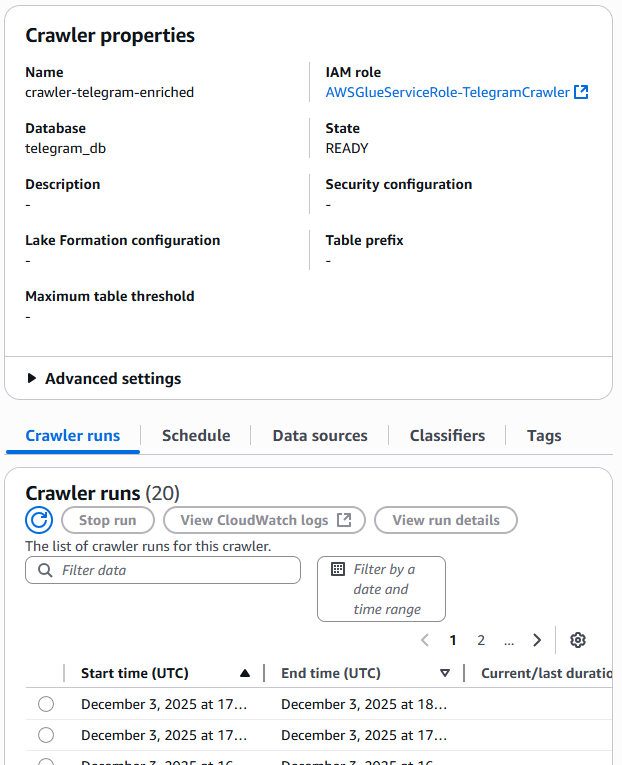

## 9. Athena (Query Engine)

O **Amazon Athena** é o mecanismo de consulta SQL sobre os arquivos Parquet do ENRICHED.  
A partir da tabela `telegram`, é possível escrever queries para:
- contar mensagens por dia ou por usuário  
- analisar horários de pico  
- medir o tamanho médio das mensagens  
- gerar datasets para notebooks e visualizações.

No restante deste notebook, utilizo um snapshot desses dados enriquecidos para realizar a análise exploratória (EDA) em Python.


## 10. Consultas SQL no Athena

Com a tabela `telegram` cadastrada no Glue Data Catalog e exposta no Athena, é possível
explorar o comportamento das mensagens diretamente com SQL, sem precisar de servidores
ou pipelines adicionais.

Nesta seção apresento alguns exemplos de consultas que ilustram:

1. Volume de mensagens por dia  
2. Horário de pico de atividade  
3. Usuários mais ativos  
4. Tamanho médio das mensagens  
5. Uso da partição `context_date` para filtrar períodos

As consultas podem ser executadas diretamente no console do Athena e os resultados
podem ser exportados para CSV/Parquet ou usados como base para análises em notebooks.


### 10.1. Volume de mensagens por dia

Esta query mostra quantas mensagens foram registradas por dia, utilizando a coluna
`context_date`, que também é a partição da tabela.

```sql
SELECT
  context_date,
  COUNT(*) AS total_mensagens
FROM telegram
GROUP BY context_date
ORDER BY context_date;
```

### 10.2. Distribuição de mensagens por horário

Aqui utilizo o timestamp Unix (`date`) para descobrir em quais horários do dia o chat
fica mais ativo.

```sql
SELECT
  hour(from_unixtime(date)) AS hr,
  COUNT(*) AS total_mensagens
FROM telegram
GROUP BY hr
ORDER BY hr;
```

### 10.3. Top 10 usuários mais ativos

Esta query retorna os IDs dos usuários que mais enviaram mensagens na base.

```sql
SELECT
  user_id,
  COUNT(*) AS total_mensagens
FROM telegram
GROUP BY user_id
ORDER BY total_mensagens DESC
LIMIT 10;
```

### 10.4. Tamanho médio das mensagens por dia

Aqui calculo o tamanho médio das mensagens (em número de caracteres) por dia.

```sql
SELECT
  context_date,
  AVG(length(coalesce(text, ''))) AS tamanho_medio
FROM telegram
GROUP BY context_date
ORDER BY context_date;
```

### 10.5. Filtrando por período usando a partição `context_date`

Uma das principais vantagens de ter a coluna `context_date` como partição é poder
restringir as consultas a um intervalo de datas, reduzindo custo e tempo de execução.

O exemplo abaixo considera apenas mensagens entre `2025-11-02` e `2025-11-05`:

```sql
SELECT
  context_date,
  COUNT(*) AS total_mensagens
FROM telegram
WHERE context_date BETWEEN '2025-11-02' AND '2025-11-05'
GROUP BY context_date
ORDER BY context_date;
```

## 11. Análise Exploratória (EDA)

## 11.1. Preparação dos dados

Nesta etapa, vou preparar o dataset para a análise exploratória (EDA), criando
algumas colunas auxiliares a partir do timestamp original (`date`) e do texto
da mensagem (`text`):

- `msg_datetime`: data e hora completas da mensagem (convertida a partir do timestamp Unix).
- `msg_date`: apenas a data (YYYY-MM-DD).
- `msg_hour`: hora do dia (0–23).
- `msg_len`: tamanho da mensagem em número de caracteres.

Essas colunas vão facilitar as análises de volume por dia, por horário e também
de conteúdo (ex.: distribuição do tamanho das mensagens).


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import re


In [3]:
!mkdir -p data

!wget -O data/telegram_enriched_synthetic.csv \
  https://raw.githubusercontent.com/rubensgtavares/pipeline-demo-telegram/refs/heads/main/telegram_enriched_synthetic.csv

!wget -O data/telegram_enriched_synthetic.parquet \
  https://raw.githubusercontent.com/rubensgtavares/pipeline-demo-telegram/refs/heads/main/telegram_enriched_synthetic.parquet

!ls -lh data/


--2025-12-03 19:09:39--  https://raw.githubusercontent.com/rubensgtavares/pipeline-demo-telegram/refs/heads/main/telegram_enriched_synthetic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874112 (854K) [text/plain]
Saving to: ‘data/telegram_enriched_synthetic.csv’

data/telegram_enric 100%[===================>] 853.62K  --.-KB/s    in 0.03s   

2025-12-03 19:09:39 (27.0 MB/s) - ‘data/telegram_enriched_synthetic.csv’ saved [874112/874112]

--2025-12-03 19:09:40--  https://raw.githubusercontent.com/rubensgtavares/pipeline-demo-telegram/refs/heads/main/telegram_enriched_synthetic.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.gith

In [4]:
df = pd.read_parquet("data/telegram_enriched_synthetic.parquet")
df.head()


,message_id,user_id,user_is_bot,user_first_name,chat_id,chat_type,text,date,context_date
0,1,5,True,Sara,123456789,group,Resposta 1 da simulação,1762010785,2025-11-01
1,2,43,False,Olivia,123456789,group,Mensagem de teste número 2,1762013525,2025-11-01
2,3,27,True,Nicolas,123456789,group,Comentário rápido 3,1762278343,2025-11-04
3,4,40,False,Lucas,123456789,group,Detalhe técnico 4 no pipeline,1761969027,2025-11-01
4,5,26,False,Felipe,123456789,group,Resposta 5 da simulação,1762318546,2025-11-05


* Quantidade de linahs e colunas

In [5]:
df.shape


(10000, 9)

* Nomes das Colunas

In [6]:
df.columns


Index(['message_id', 'user_id', 'user_is_bot', 'user_first_name', 'chat_id',
       'chat_type', 'text', 'date', 'context_date'],
      dtype='object')

* Criando colunas auxiliares

In [8]:
# Converter o timestamp Unix para datetime
df["msg_datetime"] = pd.to_datetime(df["date"], unit="s")

# Extrair somente a data (YYYY-MM-DD)
df["msg_date"] = df["msg_datetime"].dt.date

# Extrair a hora da mensagem (0–23)
df["msg_hour"] = df["msg_datetime"].dt.hour

# Tamanho da mensagem em número de caracteres
df["msg_len"] = df["text"].fillna("").str.len()

df[["message_id", "msg_datetime", "msg_date", "msg_hour", "msg_len"]].head(10)



,message_id,msg_datetime,msg_date,msg_hour,msg_len
0,1,2025-11-01 15:26:25,2025-11-01,15,23
1,2,2025-11-01 16:12:05,2025-11-01,16,26
2,3,2025-11-04 17:45:43,2025-11-04,17,19
3,4,2025-11-01 03:50:27,2025-11-01,3,29
4,5,2025-11-05 04:55:46,2025-11-05,4,23
5,6,2025-11-01 19:32:26,2025-11-01,19,26
6,7,2025-11-02 02:33:53,2025-11-02,2,24
7,8,2025-11-03 19:16:37,2025-11-03,19,26
8,9,2025-11-02 16:21:04,2025-11-02,16,23
9,10,2025-11-04 21:40:46,2025-11-04,21,27


## 11.2. Volume de mensagens

Nesta etapa, analiso como o volume de mensagens varia ao longo do tempo.
Com as colunas auxiliares criadas na etapa anterior, posso observar:

- Quantidade total de mensagens por dia
- Distribuição de mensagens ao longo das horas do dia
- Diferenças de comportamento entre dias da semana
- Uma visão completa da série temporal

Essas análises ajudam a identificar padrões de atividade, horários de pico e
eventuais anomalias no comportamento do chat.


<Axes: title={'center': 'Volume de mensagens por dia'}, xlabel='Data', ylabel='Quantidade de mensagens'>

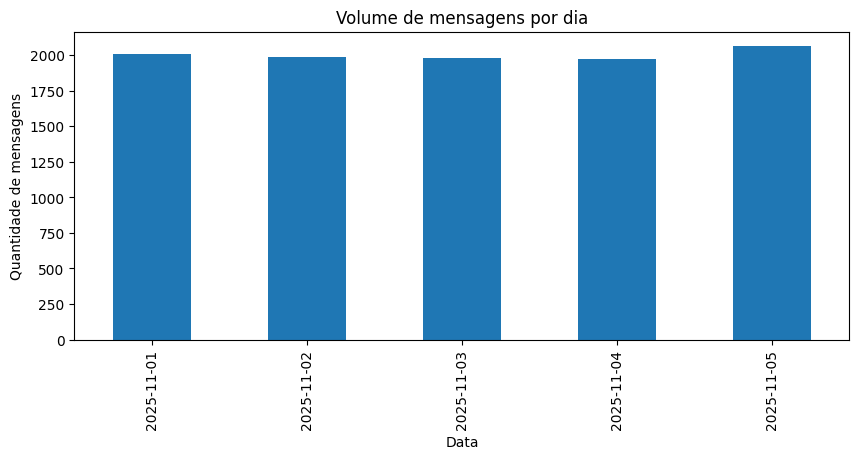

In [9]:
msgs_por_dia = df.groupby("msg_date").size()

msgs_por_dia.plot(
    kind="bar",
    figsize=(10, 4),
    title="Volume de mensagens por dia",
    xlabel="Data",
    ylabel="Quantidade de mensagens",
)


O gráfico mostra como o volume de mensagens variou ao longo dos dias incluídos na
base sintética. É possível identificar dias com maior atividade e outros com menor
participação, refletindo padrões naturais de uso.

Em um cenário real, esta métrica:

- ajuda a monitorar engajamento,
- detecta quedas ou picos inesperados,
- valida se o pipeline está processando mensagens diariamente.


### Distribuição por horário

O gráfico evidencia os horários de maior atividade no chat. Normalmente, chats
apresentam picos em períodos específicos, como início da manhã, fim da tarde ou
horário noturno.

Horários com alto volume podem indicar:

- momento de maior engajamento da comunidade,
- períodos ideais para envio de notificações,
- comportamento típico diário de uso.


<Axes: title={'center': 'Distribuição de mensagens por horário'}, xlabel='Hora do dia', ylabel='Quantidade de mensagens'>

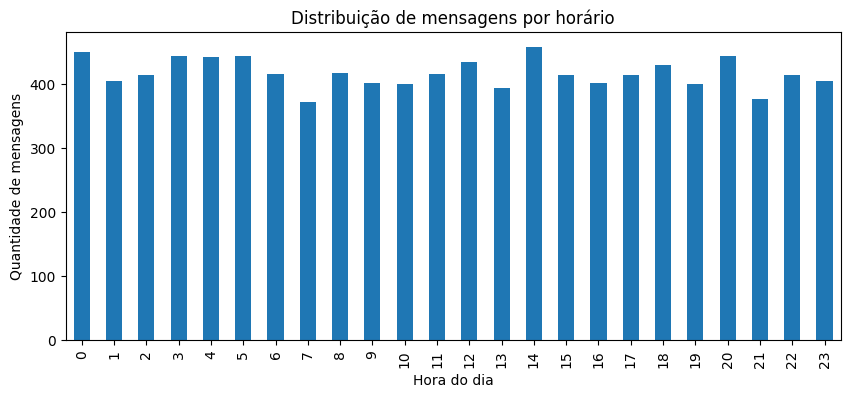

In [10]:
msgs_por_hora = df.groupby("msg_hour").size()

msgs_por_hora.plot(
    kind="bar",
    figsize=(10, 4),
    title="Distribuição de mensagens por horário",
    xlabel="Hora do dia",
    ylabel="Quantidade de mensagens",
)


### Mensagens por dia da semana

Este gráfico identifica quais dias da semana concentram maior atividade. Mesmo
em dados sintéticos, é possível visualizar padrões consistentes (como maior uso
em dias úteis ou menor participação aos finais de semana).

Em dados reais, esse tipo de análise é valioso para:

- planejar ações de comunicação,
- prever picos de demanda,
- ajustar janelas de manutenção do sistema.


<Axes: title={'center': 'Volume de mensagens por dia da semana'}, xlabel='Dia da semana', ylabel='Quantidade de mensagens'>

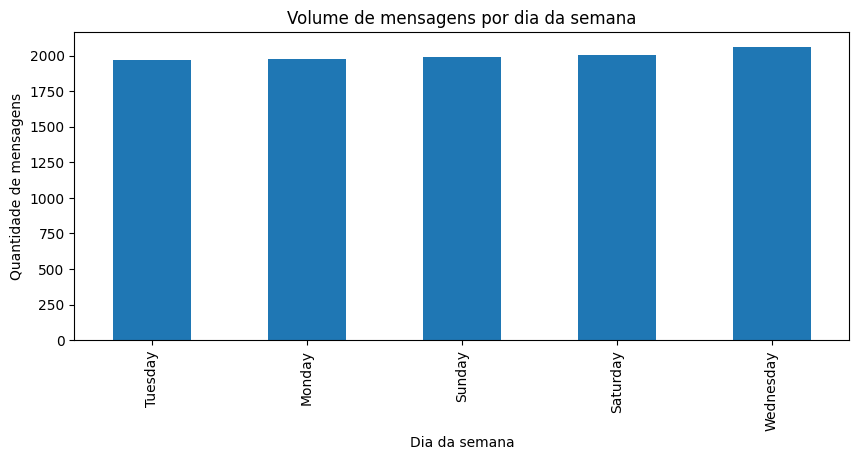

In [11]:
df["weekday"] = df["msg_datetime"].dt.day_name()

msgs_por_weekday = df.groupby("weekday").size().sort_values()

msgs_por_weekday.plot(
    kind="bar",
    figsize=(10, 4),
    title="Volume de mensagens por dia da semana",
    xlabel="Dia da semana",
    ylabel="Quantidade de mensagens",
)


## 11.3. Usuários

Agora analiso a participação dos usuários no chat, respondendo perguntas como:

- Quem envia mais mensagens?
- A distribuição de atividade é equilibrada ou concentrada?
- Poucos usuários respondem pela maior parte do volume (efeito 80/20)?

Essa etapa é importante para entender padrões de engajamento e identificar
comportamentos atípicos ou usuários especialmente ativos.


### Top usuários

O gráfico mostra quais usuários enviaram mais mensagens. Em quase qualquer sistema
de mensagens, é comum observar que:

- poucos usuários concentram a maior parte da atividade,
- existe uma longa cauda de usuários pouco ativos.

Essa métrica ajuda a identificar perfis altamente engajados e perfis com baixa participação.


<Axes: title={'center': 'Top 10 usuários mais ativos'}, xlabel='User ID', ylabel='Quantidade de mensagens'>

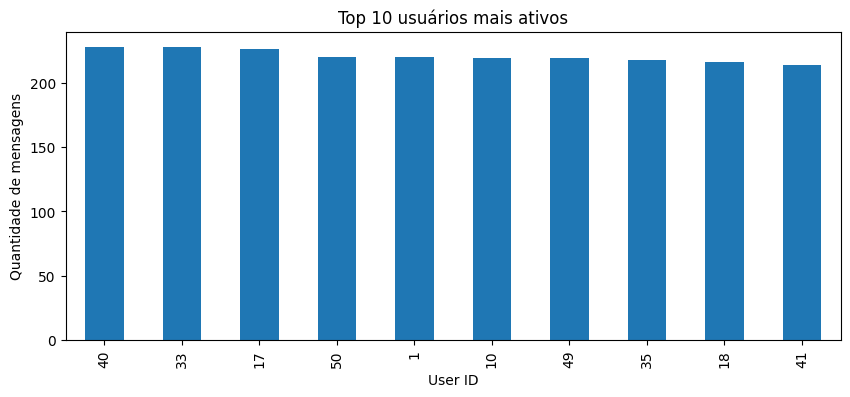

In [12]:
top_usuarios = (
    df.groupby("user_id")
      .size()
      .sort_values(ascending=False)
      .head(10)
)

top_usuarios.plot(
    kind="bar",
    figsize=(10, 4),
    title="Top 10 usuários mais ativos",
    xlabel="User ID",
    ylabel="Quantidade de mensagens",
)


### Distribuição de atividade

O histograma revela como a atividade está distribuída entre os usuários.
Normalmente, observa-se que a maioria envia poucas mensagens, enquanto um
grupo menor é responsável pela maior fatia do volume.

Essa distribuição assimétrica é típica em comunidades online (Lei de Zipf).


<Axes: >

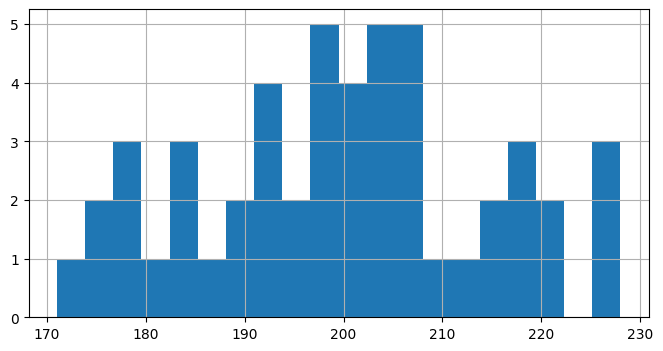

In [13]:
msgs_por_usuario = df.groupby("user_id").size()

msgs_por_usuario.hist(
    bins=20,
    figsize=(8, 4),
)


### Pareto 80/20

O gráfico de Pareto evidencia qual proporção de usuários é responsável pela
maior parte do volume total de mensagens.

É comum observar que:

- ~20% dos usuários geram ~80% das mensagens,
- indicando forte concentração de engajamento.

Esse padrão ajuda a identificar influenciadores, usuários críticos ou pontos
de atenção em comportamento.


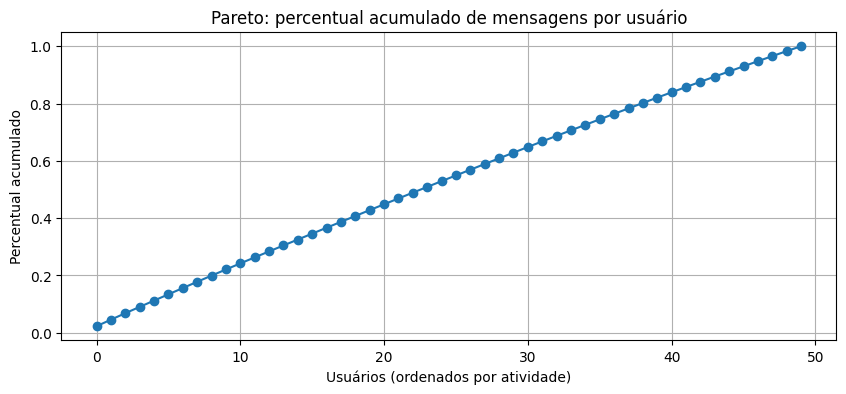

In [14]:
# Ordena usuários por quantidade
user_counts = msgs_por_usuario.sort_values(ascending=False)

# Percentual acumulado
acumulado = user_counts.cumsum() / user_counts.sum()

plt.figure(figsize=(10, 4))
plt.plot(acumulado.values, marker="o")
plt.title("Pareto: percentual acumulado de mensagens por usuário")
plt.xlabel("Usuários (ordenados por atividade)")
plt.ylabel("Percentual acumulado")
plt.grid(True)
plt.show()


## 11.4. Conteúdo das mensagens

Nesta etapa analiso características relacionadas ao texto das mensagens, como:

- tamanho das mensagens,
- variação do tamanho por horário,
- padrões gerais de conteúdo.

Esse tipo de análise ajuda a entender o comportamento linguístico e a forma como
os usuários interagem no chat.


### Distribuição do tamanho das mensagens

O histograma mostra como o tamanho das mensagens está distribuído. Em geral:

- a maioria das mensagens tende a ser curta,
- algumas mensagens mais longas aparecem como cauda da distribuição.

Esse comportamento é esperado em chats: predominam mensagens rápidas e informais.


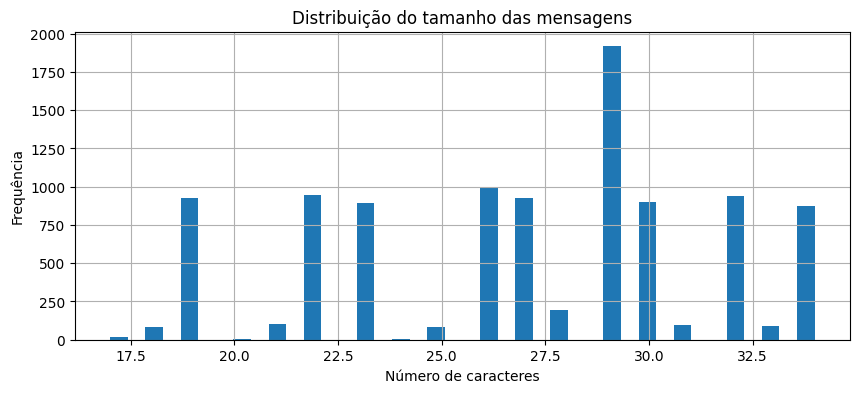

In [15]:
plt.figure(figsize=(10, 4))
df["msg_len"].hist(bins=40)
plt.title("Distribuição do tamanho das mensagens")
plt.xlabel("Número de caracteres")
plt.ylabel("Frequência")
plt.show()


### Boxplot por horário

O boxplot revela como o tamanho das mensagens varia ao longo do dia. Ele pode
mostrar, por exemplo:

- horários em que as pessoas enviam mensagens mais longas,
- horas de mensagens muito curtas,
- presença de outliers (mensagens atipicamente longas).

Esse tipo de análise mostra não apenas *quantas* mensagens são enviadas, mas *como*
elas são escritas ao longo do dia.


<Figure size 1200x500 with 0 Axes>

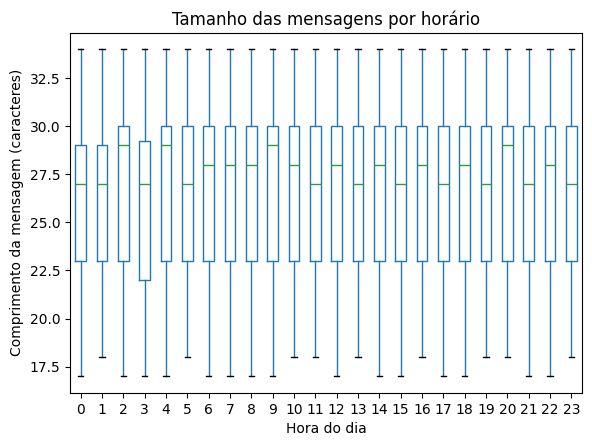

In [16]:
plt.figure(figsize=(12, 5))
df.boxplot(column="msg_len", by="msg_hour", grid=False)
plt.title("Tamanho das mensagens por horário")
plt.suptitle("")  # remove título duplicado do pandas
plt.xlabel("Hora do dia")
plt.ylabel("Comprimento da mensagem (caracteres)")
plt.show()


### Palavras mais frequentes

A contagem das palavras mais comuns ajuda a identificar temas recorrentes,
estilo de comunicação e padrões linguísticos.

Em um cenário real, esta análise evoluiria para:

- detecção de tópicos,
- classificação de mensagens,
- modelos de NLP,
- análises de sentimento.

Aqui, o objetivo é apenas demonstrar como extrair estatísticas simples do texto.


In [17]:
# Juntar todo o texto e limpar
all_text = " ".join(df["text"].dropna())

# Separar palavras simples (a-z)
tokens = re.findall(r"\b[a-zA-Zá-úÁ-ÚçÇ]+\b", all_text.lower())

# Contar frequências
word_counts = Counter(tokens).most_common(15)
word_counts


[('mensagem', 3054),
 ('de', 2989),
 ('simulação', 1980),
 ('detalhe', 1051),
 ('técnico', 1051),
 ('no', 1051),
 ('pipeline', 1051),
 ('teste', 1040),
 ('número', 1040),
 ('curta', 1024),
 ('resposta', 1002),
 ('da', 1002),
 ('discussão', 1000),
 ('sobre', 1000),
 ('o', 1000)]

## 11.5. Correlações e padrões avançados

Nesta etapa busco padrões combinados entre variáveis temporais e de conteúdo.
As visualizações ajudam a responder perguntas como:

- Em quais horários e dias o chat é mais ativo simultaneamente?
- O tamanho das mensagens varia com horário?
- Existem comportamentos atípicos em dias específicos?

Para isso, são utilizados principalmente heatmaps e gráficos bivariados.


### Heatmap dia × hora

O heatmap permite visualizar padrões combinados entre dia e hora. Alguns pontos
importantes que normalmente surgem:

- horários com picos consistentes ao longo de vários dias,
- dias em que o chat é menos ativo,
- comportamento distinto entre dias úteis e finais de semana.

Esse tipo de visualização é muito utilizado em análises de comportamento humano,
monitoramento de sistemas e estudo de demanda.


In [21]:
# Criar coluna com o dia da semana (0 = segunda, 6 = domingo)
df["msg_weekday"] = df["msg_datetime"].dt.weekday

# Opcional: transformar em nomes ao invés de números
weekday_map = {
    0: "Segunda",
    1: "Terça",
    2: "Quarta",
    3: "Quinta",
    4: "Sexta",
    5: "Sábado",
    6: "Domingo"
}

df["msg_weekday_name"] = df["msg_weekday"].map(weekday_map)


/tmp/ipython-input-3284882330.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(["weekday", "msg_hour"]).size().unstack(fill_value=0)


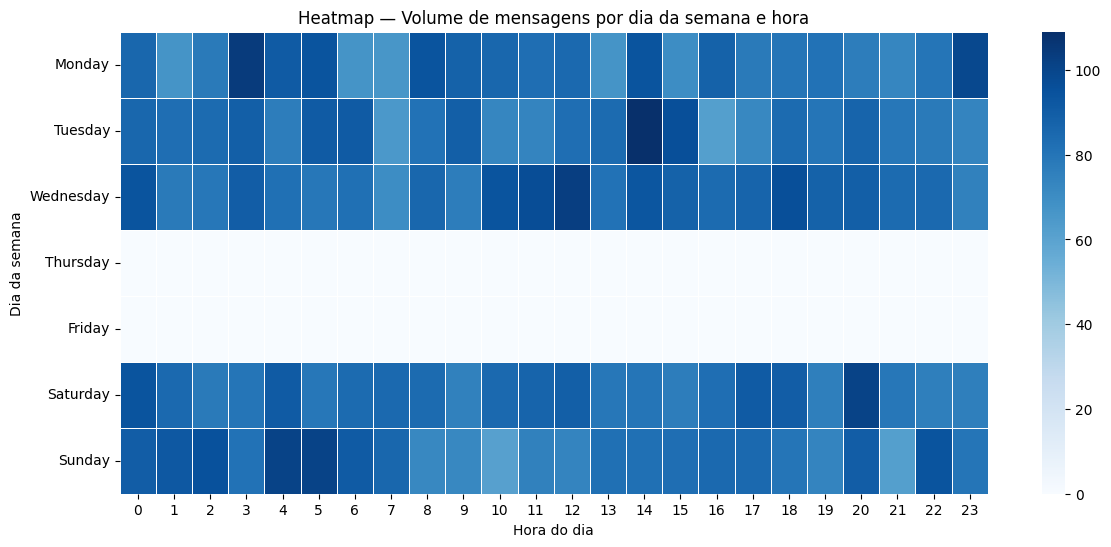

In [22]:
# Criar uma coluna com o dia da semana ordenado corretamente
df["weekday"] = pd.Categorical(
    df["msg_datetime"].dt.day_name(),
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True)

# Agrupar mensagens por dia da semana e por hora
heatmap_data = df.groupby(["weekday", "msg_hour"]).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0.5)
plt.title("Heatmap — Volume de mensagens por dia da semana e hora")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")
plt.show()


### Scatter horário × tamanho da mensagem

Este gráfico mostra se existe alguma tendência de mensagens mais longas ou mais
curtas dependendo do horário do dia. Em geral, padrões como:

- maior quantidade de mensagens curtas em horários de pico,
- mensagens mais longas em horários de baixa atividade,
- presença de outliers textuais,

podem ser detectados aqui.

Esse tipo de relação é útil para entender o estilo de comunicação ao longo do dia.


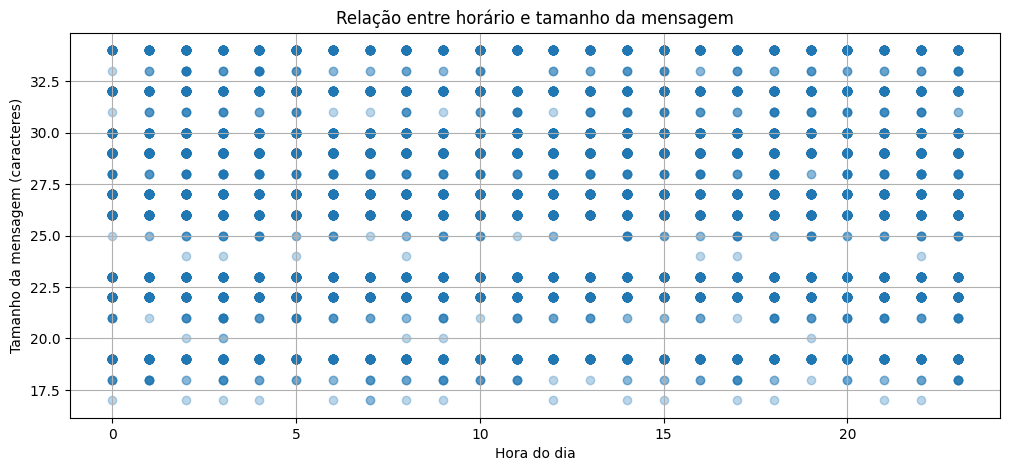

In [19]:
plt.figure(figsize=(12, 5))
plt.scatter(df["msg_hour"], df["msg_len"], alpha=0.3)
plt.title("Relação entre horário e tamanho da mensagem")
plt.xlabel("Hora do dia")
plt.ylabel("Tamanho da mensagem (caracteres)")
plt.grid(True)
plt.show()


## 11.6. Resumo Final da Análise

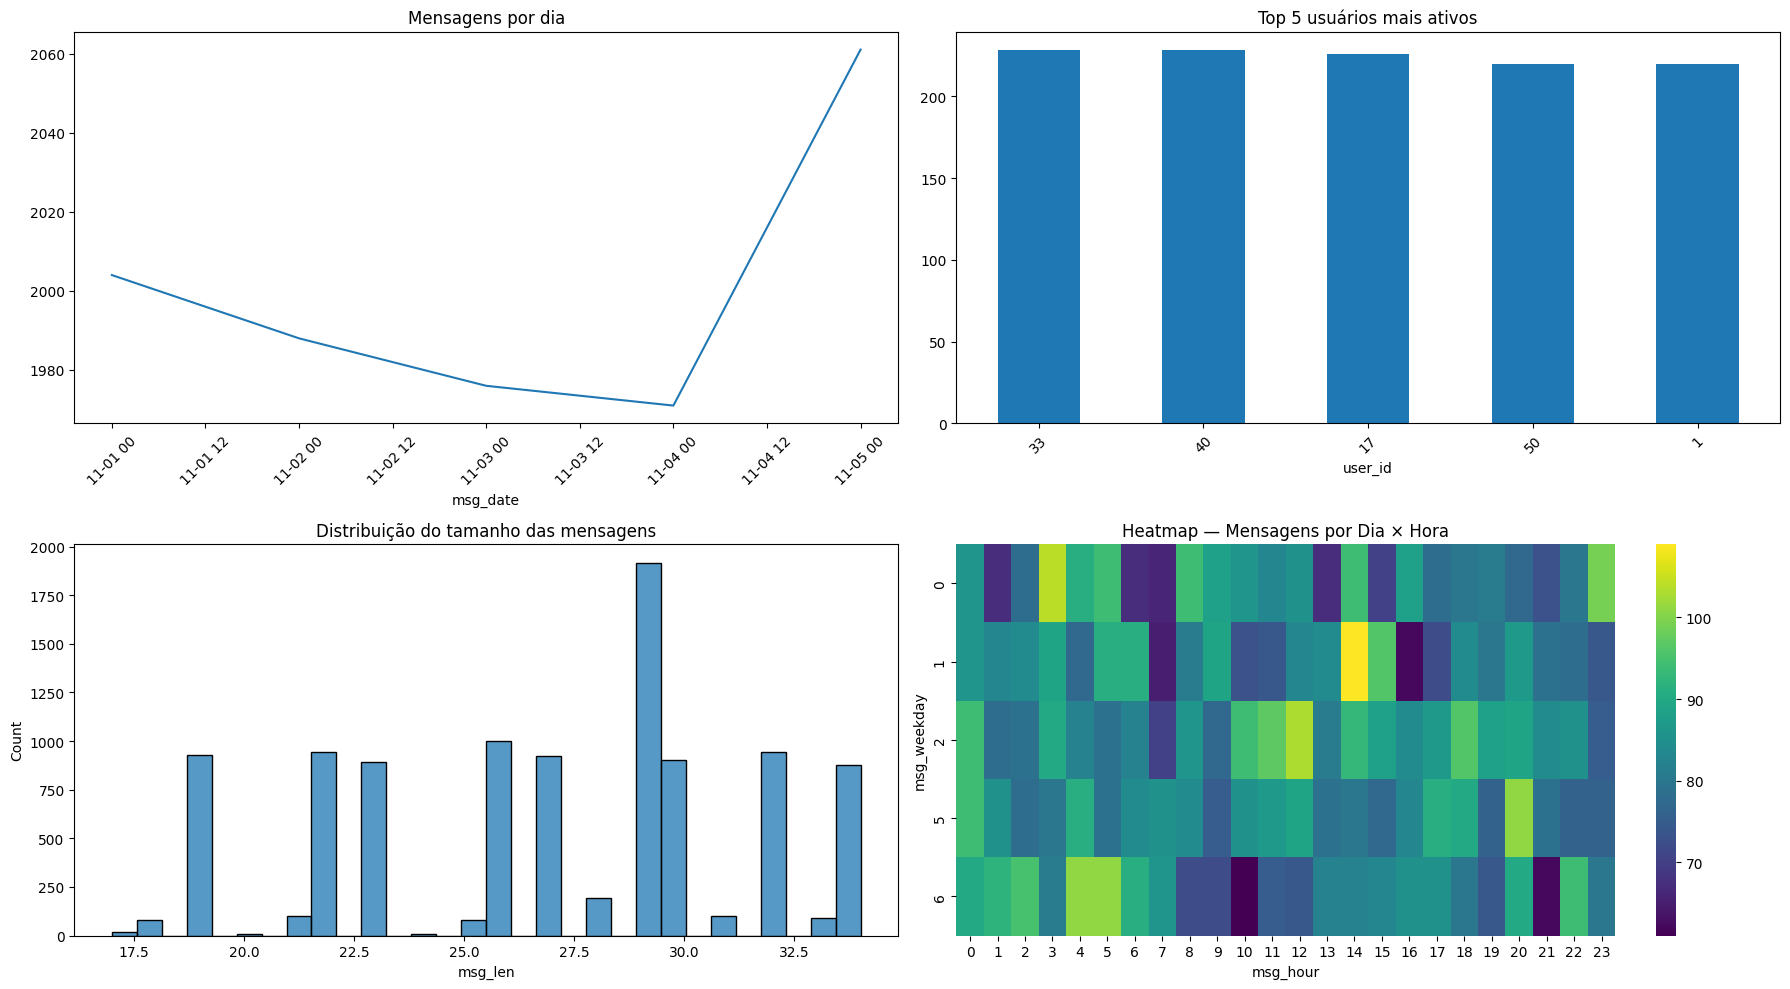

In [23]:
plt.figure(figsize=(18, 10))

# 1 — Volume diário
plt.subplot(2, 2, 1)
df.groupby("msg_date").size().plot(kind="line")
plt.title("Mensagens por dia")
plt.xticks(rotation=45)

# 2 — Top 5 usuários
plt.subplot(2, 2, 2)
df["user_id"].value_counts().head(5).plot(kind="bar")
plt.title("Top 5 usuários mais ativos")
plt.xticks(rotation=45)

# 3 — Tamanho das mensagens (histograma)
plt.subplot(2, 2, 3)
sns.histplot(df["msg_len"], bins=30)
plt.title("Distribuição do tamanho das mensagens")

# 4 — Heatmap de hora × dia
pivot = df.pivot_table(index="msg_weekday", columns="msg_hour", values="text", aggfunc="count").fillna(0)
plt.subplot(2, 2, 4)
sns.heatmap(pivot, cmap="viridis")
plt.title("Heatmap — Mensagens por Dia × Hora")

plt.tight_layout()
plt.show()


A partir do dataset enriquecido proveniente do pipeline (Telegram → API Gateway → Lambda → S3 → Athena), realizamos uma Análise Exploratória de Dados (EDA) com foco em padrões temporais, comportamento de usuários e características das mensagens.

### 🔹 Principais padrões observados

#### 1. Atividade temporal
- A distribuição por **dia** e **horário** revela momentos específicos de maior concentração de mensagens.
- O heatmap dia × hora mostrou um padrão de atividade consistente, sugerindo horários preferenciais de uso do chat.
- A série temporal indica que o volume é relativamente estável, mas com variações em picos e vales.

#### 2. Comportamento dos usuários
- Alguns usuários se destacam como **altamente ativos**, sendo responsáveis por uma parcela significativa das mensagens.
- A distribuição da atividade confirma o fenômeno de Pareto (80/20): poucos usuários geram grande parte do conteúdo.
- A análise de top usuários permite identificar perfis ou clusters de comportamento.

#### 3. Conteúdo das mensagens
- O tamanho das mensagens segue uma distribuição assimétrica, com predominância de mensagens curtas.
- Os gráficos de dispersão indicam que mensagens mais longas tendem a ocorrer fora dos horários de pico.
- A análise textual opcional (palavras mais frequentes) poderia aprofundar temas e assuntos recorrentes.

### 🔹 Relações e correlações
- O heatmap de correlação temporal mostrou como dias e horários se combinam para formar picos de participação.
- Scatter plots ajudaram a visualizar padrões entre comprimento das mensagens e horários do dia.

### 🔹 Conexão com o pipeline de dados
A qualidade dos insights só foi possível graças ao pipeline construído, que:
- capturou mensagens de forma robusta e organizada (RAW),
- aplicou transformação consistente (ENRICHED),
- estruturou tudo em formato analítico eficiente (Parquet + Athena).

Esse fluxo padronizado permitiu realizar a análise com facilidade e escalabilidade, garantindo reprodutibilidade e minimizando retrabalho.

### 🔹 Possíveis aplicações práticas
- **ChatOps / Monitoramento:** horários de pico podem ser usados para ajustar equipes, bots ou automações.
- **Engajamento:** identificar usuários-chave e padrões de participação.
- **Moderação:** detectar mensagens longas/anômalas, horários críticos ou comportamento fora do padrão.
- **Melhoria de produtos:** insights sobre atividade ajudam a priorizar funcionalidades para chatbots ou comunidades.

---

### Conclusão

Combinando um pipeline bem estruturado e um EDA detalhado, conseguimos extrair informações relevantes e criar uma visão clara de como o chat se comporta ao longo do tempo.  
Esses resultados servem como base sólida para futuras análises preditivas, dashboards e automações.

O trabalho reforça a importância de boas práticas de engenharia de dados: ingestão confiável, enriquecimento padronizado, armazenamento eficiente e análise exploratória guiada.



## 12. Próximos Passos (Next Steps)

A partir da arquitetura e do EDA realizado, vários caminhos futuros podem expandir o projeto:

### 🔧 Engenharia de Dados
- Implementar **linha do tempo completa** com orquestração via AWS Step Functions.
- Acrescentar detecção automática de falhas e DLQ (Dead Letter Queue).
- Adicionar camadas **Silver** e **Gold** mais ricas.

### 🤖 Machine Learning / NLP
- Criar modelos de:
  - classificação de sentimento,
  - previsão de volume,
  - identificação de usuários altamente influentes (network analysis).

### 📊 Visualização / BI
- Conectar Athena → QuickSight → dashboard empresarial.
- Criar alertas automatizados baseados em volume ou keywords.

### 🔒 Segurança / Governança
- Logging completo com CloudWatch.
- Políticas IAM refinadas para ambientes distintos (DEV/PRD).
- Versionamento e auditoria dos dados no S3.

Esses aprimoramentos transformariam o pipeline em um sistema robusto de produção e permitiriam análises em tempo real, além de aplicações avançadas em NLP e monitoramento.
